## Hopfield. Collective memory. Recall experiment, based on the learned graphs

Goal: Verify if the learned weight-matrix can be used as a Hopfield network. If so, the main signal (corresponding to the month and main events) should be emphasized.

Experiment step-by-step:
1. Take a month-learned graph.
2. Extract learned weight-matrix.
3. Take signal, that was used to learn the graph.
4. Emulate recall, using Hopfield model (dot product of signal and weight-matrix).
5. Observe, if the recalled signal emphsizes the main signal.

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import matplotlib.colors as colors
from scipy import sparse
%matplotlib inline

In [2]:
PATH_DATA = "/mnt/data/git/WikiBrain/src/main/resources/hopfield/"
MONTH = "signal"

### Signal

In [3]:
# with open(PATH_DATA + MONTH +".txt") as f:
#     content = f.readlines()

In [4]:
# content = content[0]
# content = content.split(')')
# content = map(lambda row: row.strip('(').strip('[').strip(']').replace('[','').replace('.0',''),content)
# content = map(lambda row: row.split(','), content)
# content = [[float(x) for x in row if x != ''] for row in content][:len(content)-1]
# np.save(PATH_DATA + "content.npy", content)

In [5]:
content = np.load(PATH_DATA + "content.npy")

In [6]:
ids = []
for row in content:
    ids.append(int(row[0]))

In [7]:
ids_dict = {}
for i, a in enumerate(ids):
    ids_dict[a] = i

In [8]:
ids_dict_swap = {}
for i, a in enumerate(ids):
    ids_dict_swap[i] = a

### Adjacency

In [9]:
import csv
with open(PATH_DATA + '/stddev/edges_apr_full.csv') as f:
    data=[tuple(line) for line in csv.reader(f)]

In [10]:
row = [ids_dict[int(line[0])] for line in data]
col = [ids_dict[int(line[1])] for line in data]
data = [float(line[2]) if float(line[2]) >= 0.0 else 0.0 for line in data] #learned
# data = [float(line[2]) for line in data] #learned
# data = [1.0 if float(line[2]) > 1.0 else 0.0 for line in data] #structure
# data = [1.0 if float(line[2]) > 1.0 else 0.0 for line in data] #structure
# data = [float(line[2]) for line in data] #all

In [11]:
# adjacency for a cluster
# list_of_ids = [ids_dict_swap[x] for x in cluster_rows]
# row = [ids_dict[int(line[0])] for line in data]
# col = [ids_dict[int(line[1])] for line in data]
# data = [float(line[2]) if (float(line[2]) > 1.0 and int(line[0]) in list_of_ids and int(line[1]) in list_of_ids) else 0.0 for line in data] #learned

In [12]:
from scipy.sparse import csr_matrix

In [13]:
W = csr_matrix((data, (row, col)), shape=(len(ids_dict), len(ids_dict)))

In [14]:
W = W + W.transpose()

### ID-Title

In [15]:
import csv
with open(PATH_DATA + 'id_title.csv') as f:
    data_id_title=[tuple([int(line[0]), line[1]]) for line in csv.reader(f)]

In [16]:
data_id_title = dict(data_id_title)

In [17]:
title = 'Super_Bowl'

In [18]:
page_id = [ key for key,val in data_id_title.items() if val==title ][0]

In [19]:
page_id

27718

In [20]:
data_id_title[page_id]

'Super_Bowl'

In [21]:
nRow = ids_dict[page_id]
print 'Row number for page ' + title +  ": " + str(nRow)

Row number for page Super_Bowl: 68859


In [22]:
def getTitleByRow(requested_row):
    requested_id = ids_dict_swap[requested_row]
    return data_id_title[requested_id]

In [23]:
## put a constant signal to one of the nodes
# content.fill(-1)
# content = np.insert(content, nRow, 1, axis=0)
# content = content[:np.shape(content)[0]-1,:]

### Clusters

In [24]:
CHARLIE_HEBDO = '/clusters/Charlie_Hebdo_one_week_5_12_January.csv'
GERMANWINGS = '/clusters/GermanWings_week.csv'

FERGUSON = '/clusters/ferguson_week_stddev.csv'

In [25]:
with open(PATH_DATA + FERGUSON) as f:
    cluster = f.readlines()
cluster = [x.strip() for x in cluster]

In [26]:
cluster = map(lambda l: (int(l[0]), l[1]), map(lambda t: t.split(','), cluster))

In [27]:
import string
printable = set(string.printable)
cluster = map(lambda l: (int(l[0]), filter(lambda x: x in printable, l[1])), cluster)

In [28]:
cluster = dict(cluster) # (id:title)

In [29]:
cluster_rows = [ids_dict[pId] for pId in cluster.keys()]

In [30]:
len(cluster_rows)

35

### NFL cluster

In [31]:
# nfl_teams = ['Buffalo_Bills','Miami_Dolphins','New_England_Patriots','New_York_Jets','Baltimore_Ravens','Cincinnati_Bengals','Cleveland_Browns','Pittsburgh_Steelers','Houston_Texans','Indianapolis_Colts','Jacksonville_Jaguars','Tennessee_Titans','Denver_Broncos','Kansas_City_Chiefs','Los_Angeles_Chargers','Oakland_Raiders','Dallas_Cowboys','New_York_Giants','Philadelphia_Eagles','Washington_Redskins','Chicago_Bears','Detroit_Lions','Green_Bay_Packers','Minnesota_Vikings','Atlanta_Falcons','Carolina_Panthers','New_Orleans_Saints','Tampa_Bay_Buccaneers','Arizona_Cardinals','Los_Angeles_Rams','San_Francisco_49ers','Seattle_Seahawks']
# page_ids = [ key for key,val in data_id_title.items() if val in nfl_teams ]
# cluster_rows = [ids_dict[pID] for pID in page_ids]

### Binarize signal

In [32]:
# def binarize(x):
#     if x>0.0:
#         x = 1.0
#     else: x = -1.0
#     return x

In [33]:
# binarized = np.array([[binarize(x) for x in row] for row in content])
# np.save(PATH_DATA + "binarized.npy", binarized)
# binarized = content

In [34]:
binarized = np.load(PATH_DATA + "binarized.npy")

In [35]:
# binarized = content

### Low-pass filter

In [36]:
def savitzky_golay(y, window_size=747, order=2, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### Plot

In [37]:
# months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']
months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
x_month = [i for i in np.arange(8*24, len(content[0]), 30*24)]
x_month[1] = x_month[1] + 24 #October
x_month[2] = x_month[2] + 24 #November
x_month[3] = x_month[3] + 48 #December
x_month[4] = x_month[4] + 72 #January
x_month[5] = x_month[5] + 24 #February
x_month[6] = x_month[6] + 48 #March
x_month[7] = x_month[7] + 48 #April

In [87]:
from pylab import rcParams
rcParams['figure.figsize'] = 90, 40
rcParams['xtick.labelsize'] = 170
rcParams['ytick.labelsize'] = 170
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [39]:
rcParams['axes.facecolor'] = 'black'

### Original signal

In [40]:
#+1 makes activations positive only
# summary = [sum(l+1) for l in binarized.T]
summary = np.array(csr_matrix(binarized+1).sum(axis = 0))[0]

In [41]:
# pl.plot(summary[1:] - min(summary[1:]), 'r')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'g')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.show()

In [42]:
#filter over 169 hours (a week) time window with a polynomial of order 2
#month = 747 hours
filtered = savitzky_golay(summary[1:], window_size=721)

In [43]:
# pl.plot(filtered - min(filtered), 'r')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# #pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# #pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# #pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.show()

In [44]:
#activations

# pl.imshow(binarized, cmap='Greys', aspect='auto')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.colorbar()
# pl.show()

### Degraded signal

In [45]:
# def degrade(patterns,noise):
#     #This allows you to add noise to a pattern
#     sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
#     out=sgn(patterns)
#     return out

In [46]:
# degraded = csr_matrix(degrade(np.array(binarized), 0.2))

In [47]:
# degraded = csr_matrix(degrade(np.array(binarized), 0.4))
degraded = csr_matrix(binarized)

In [48]:
#degraded signal

# pl.imshow(degraded, cmap='Greys', aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.colorbar()
# pl.show()

### Recall

In [49]:
r,p = degraded.shape

In [50]:
# def recall(W, patterns, steps=5):
#     #The tests the network. You give it a pattern and see what it produces
#     from numpy import vectorize, dot #vector calculus functions
#     sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
#     for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
#         print "." * (_ + 1)
#         patterns = W.dot(patterns) #adjust the neuron activity to reflect the weights
#     return sgn(patterns.todense()) #return the final pattern

In [51]:
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        print "." * (_ + 1)
        patterns = W.dot(patterns) #adjust the neuron activity to reflect the weights
        data = patterns.data
        patterns.data = np.array([-1 if x<0 else +1 for x in data])
    return patterns.todense() #return the final pattern

In [52]:
recalled = recall(W/r, degraded, steps=1)

.


In [53]:
# titles = [getTitleByRow(row).decode('utf-8') for row in range(nRow-10,nRow+10)]
# titles = [getTitleByRow(row).decode('utf-8') for row in cluster_rows]

In [54]:
# #original
# pl.figure(figsize=(100,200))
# pl.imshow(binarized[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.yticks(range(0,len(titles)), titles)
# pl.colorbar()

In [55]:
# #degraded
# pl.figure(figsize=(100,200))
# # pl.figure(figsize=(100,50))
# # pl.imshow(degraded.todense()[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
# pl.imshow(degraded.todense()[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.yticks(range(0,len(titles)), titles)
# pl.colorbar()

In [56]:
# #recalled
# pl.figure(figsize=(100,200))
# # pl.figure(figsize=(100,50))
# # pl.imshow(recalled[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
# pl.imshow(recalled[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.yticks(range(0,len(titles)), titles)
# pl.colorbar()

In [57]:
# summary_recalled = [sum(l + 1) for l in np.array(recalled).T]
summary_recalled = np.array(csr_matrix(recalled+1).sum(axis = 0))[0]

In [58]:
# pl.plot(summary_recalled, 'r')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# #pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# #pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# #pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# # pl.axvline(x = x_month[3] + 17*24, linewidth=3, color = 'b') #
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.show()

In [59]:
filtered_recalled = savitzky_golay(summary_recalled, window_size=721)

In [60]:
# pl.plot(filtered_recalled - min(filtered_recalled), 'r')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# #pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# #pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# #pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.show()

In [61]:
#activations

# pl.imshow(recalled, cmap='Greys', aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.colorbar()
# pl.show()

### Original vs Recalled

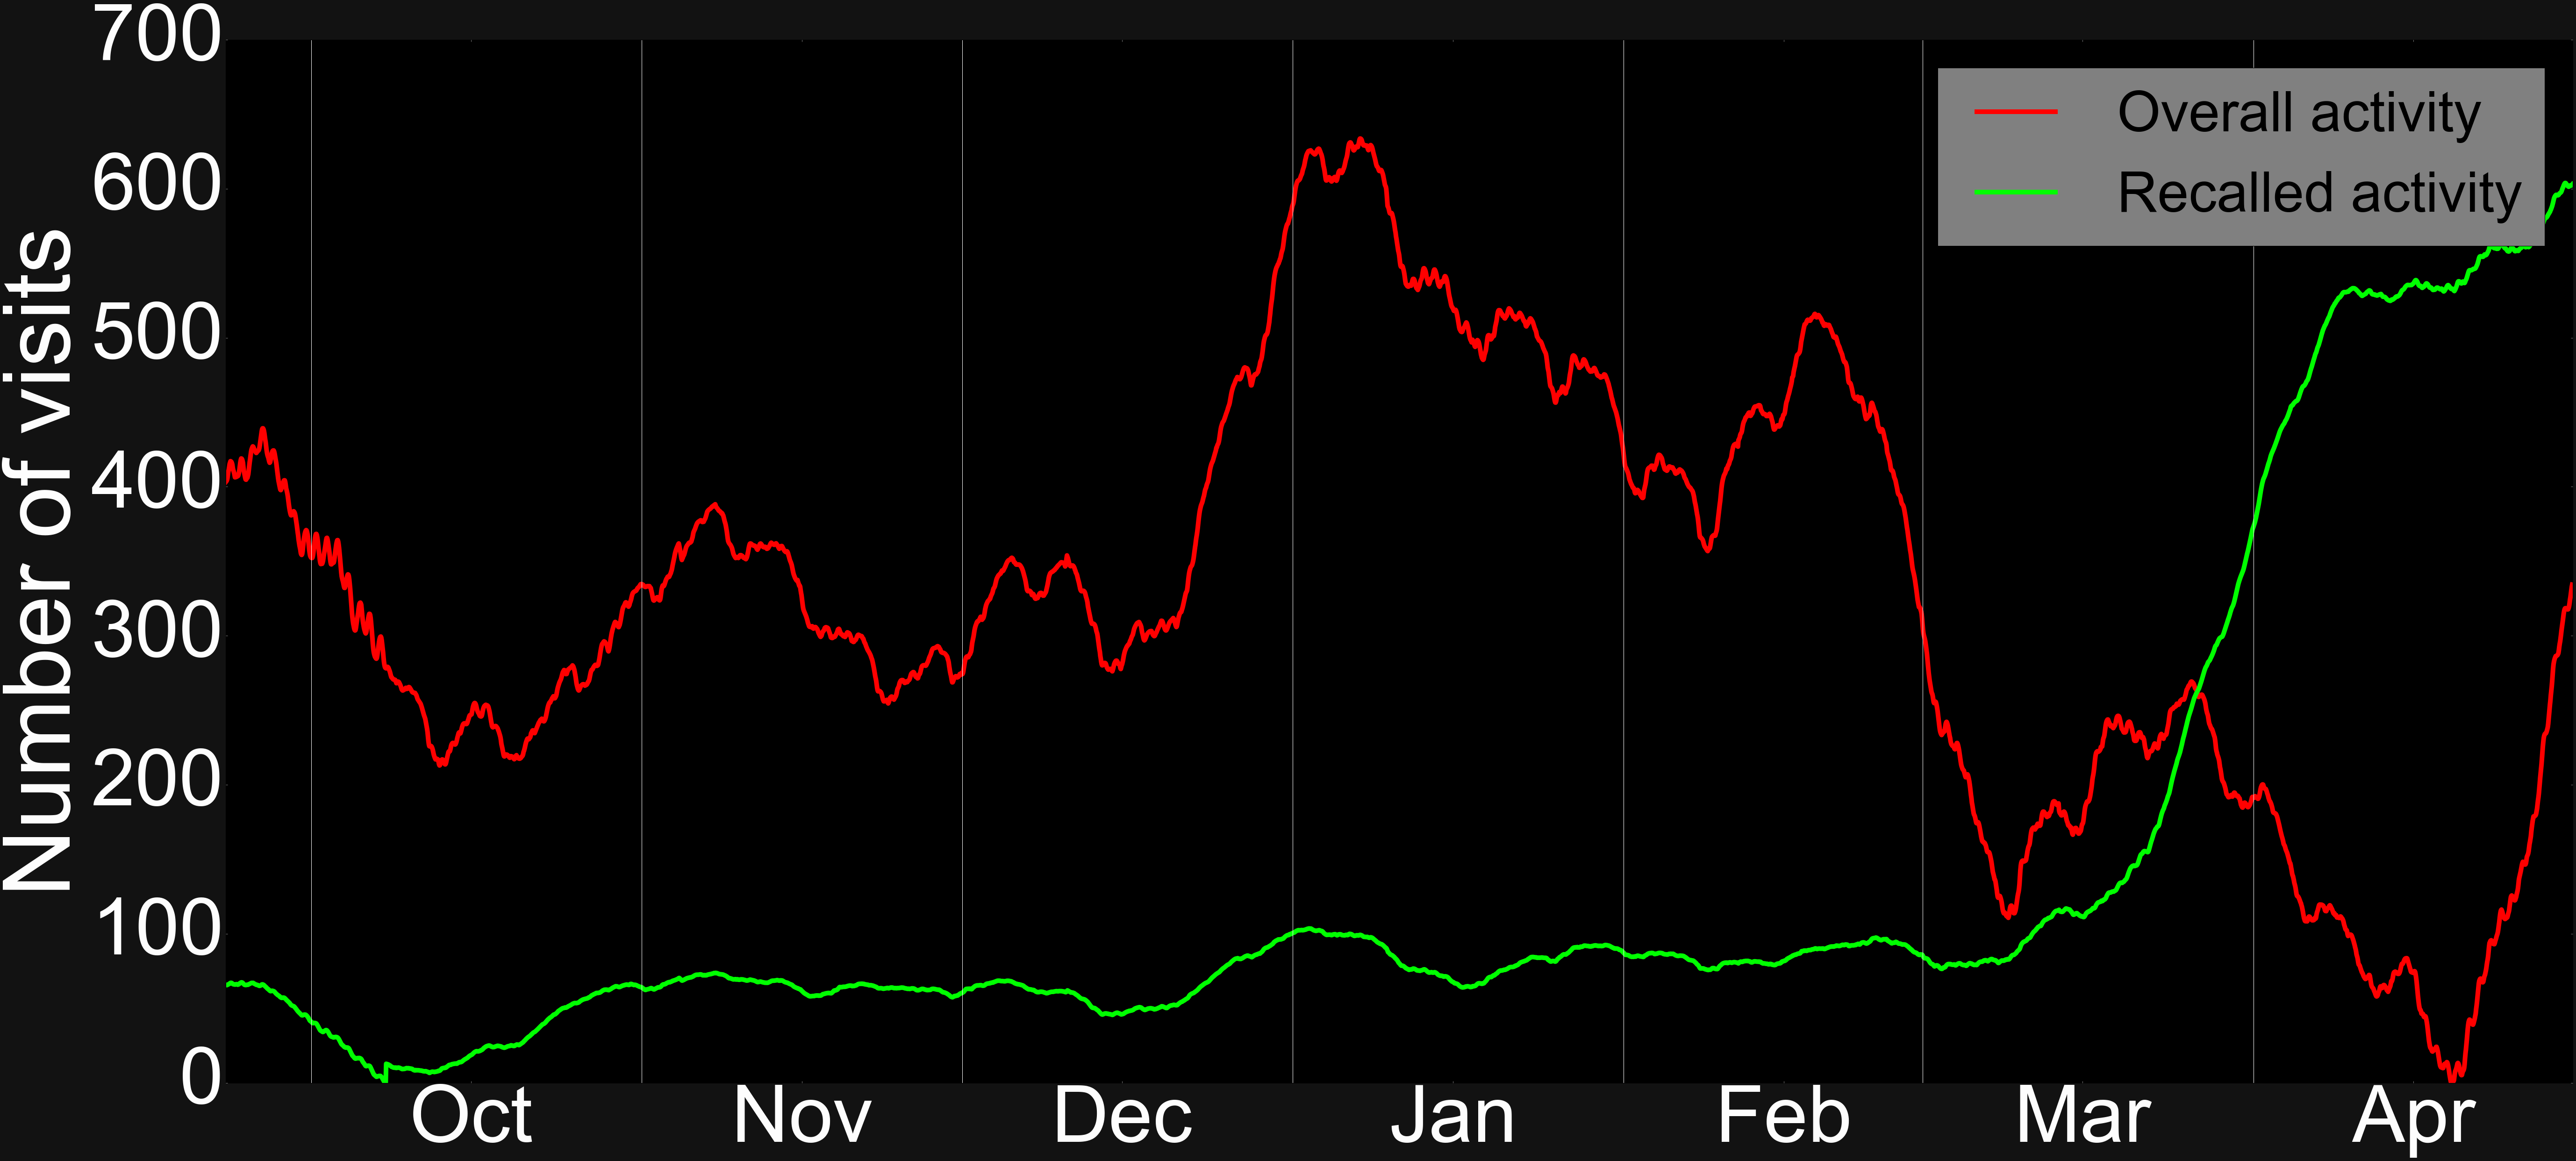

In [99]:
rcParams['axes.facecolor'] = 'black'
rcParams['axes.labelcolor'] = 'w'
rcParams["legend.facecolor"] = 'grey'
overall, = pl.plot(filtered - min(filtered), 'r', linewidth=10, label='Overall activity')
recalled, = pl.plot(filtered_recalled - min(filtered_recalled), '#00FF00', linewidth=10, label='Recalled activity')
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'w')
# pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# pl.axvline(x = x_month[4] + 22*24, linewidth=5, color = 'm') #Golden Globe
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.ylabel("Number of visits", fontsize=200)
pl.legend(handles=[overall, recalled], fontsize=120)
pl.xlim(0,np.shape(difference)[0])
pl.show()

In [100]:
d = np.zeros(len(filtered_recalled[1:]))

In [101]:
difference = filtered_recalled[1:] - min(filtered_recalled[1:]) - (filtered - min(filtered))

In [102]:
x = np.arange(0,len(difference),1)

In [103]:
pl.rcParams['axes.facecolor'] = 'black'
rcParams["ytick.color"] = "w"
rcParams["xtick.color"] = "w"
rcParams["figure.facecolor"] = '#121212'

(0, 5278)

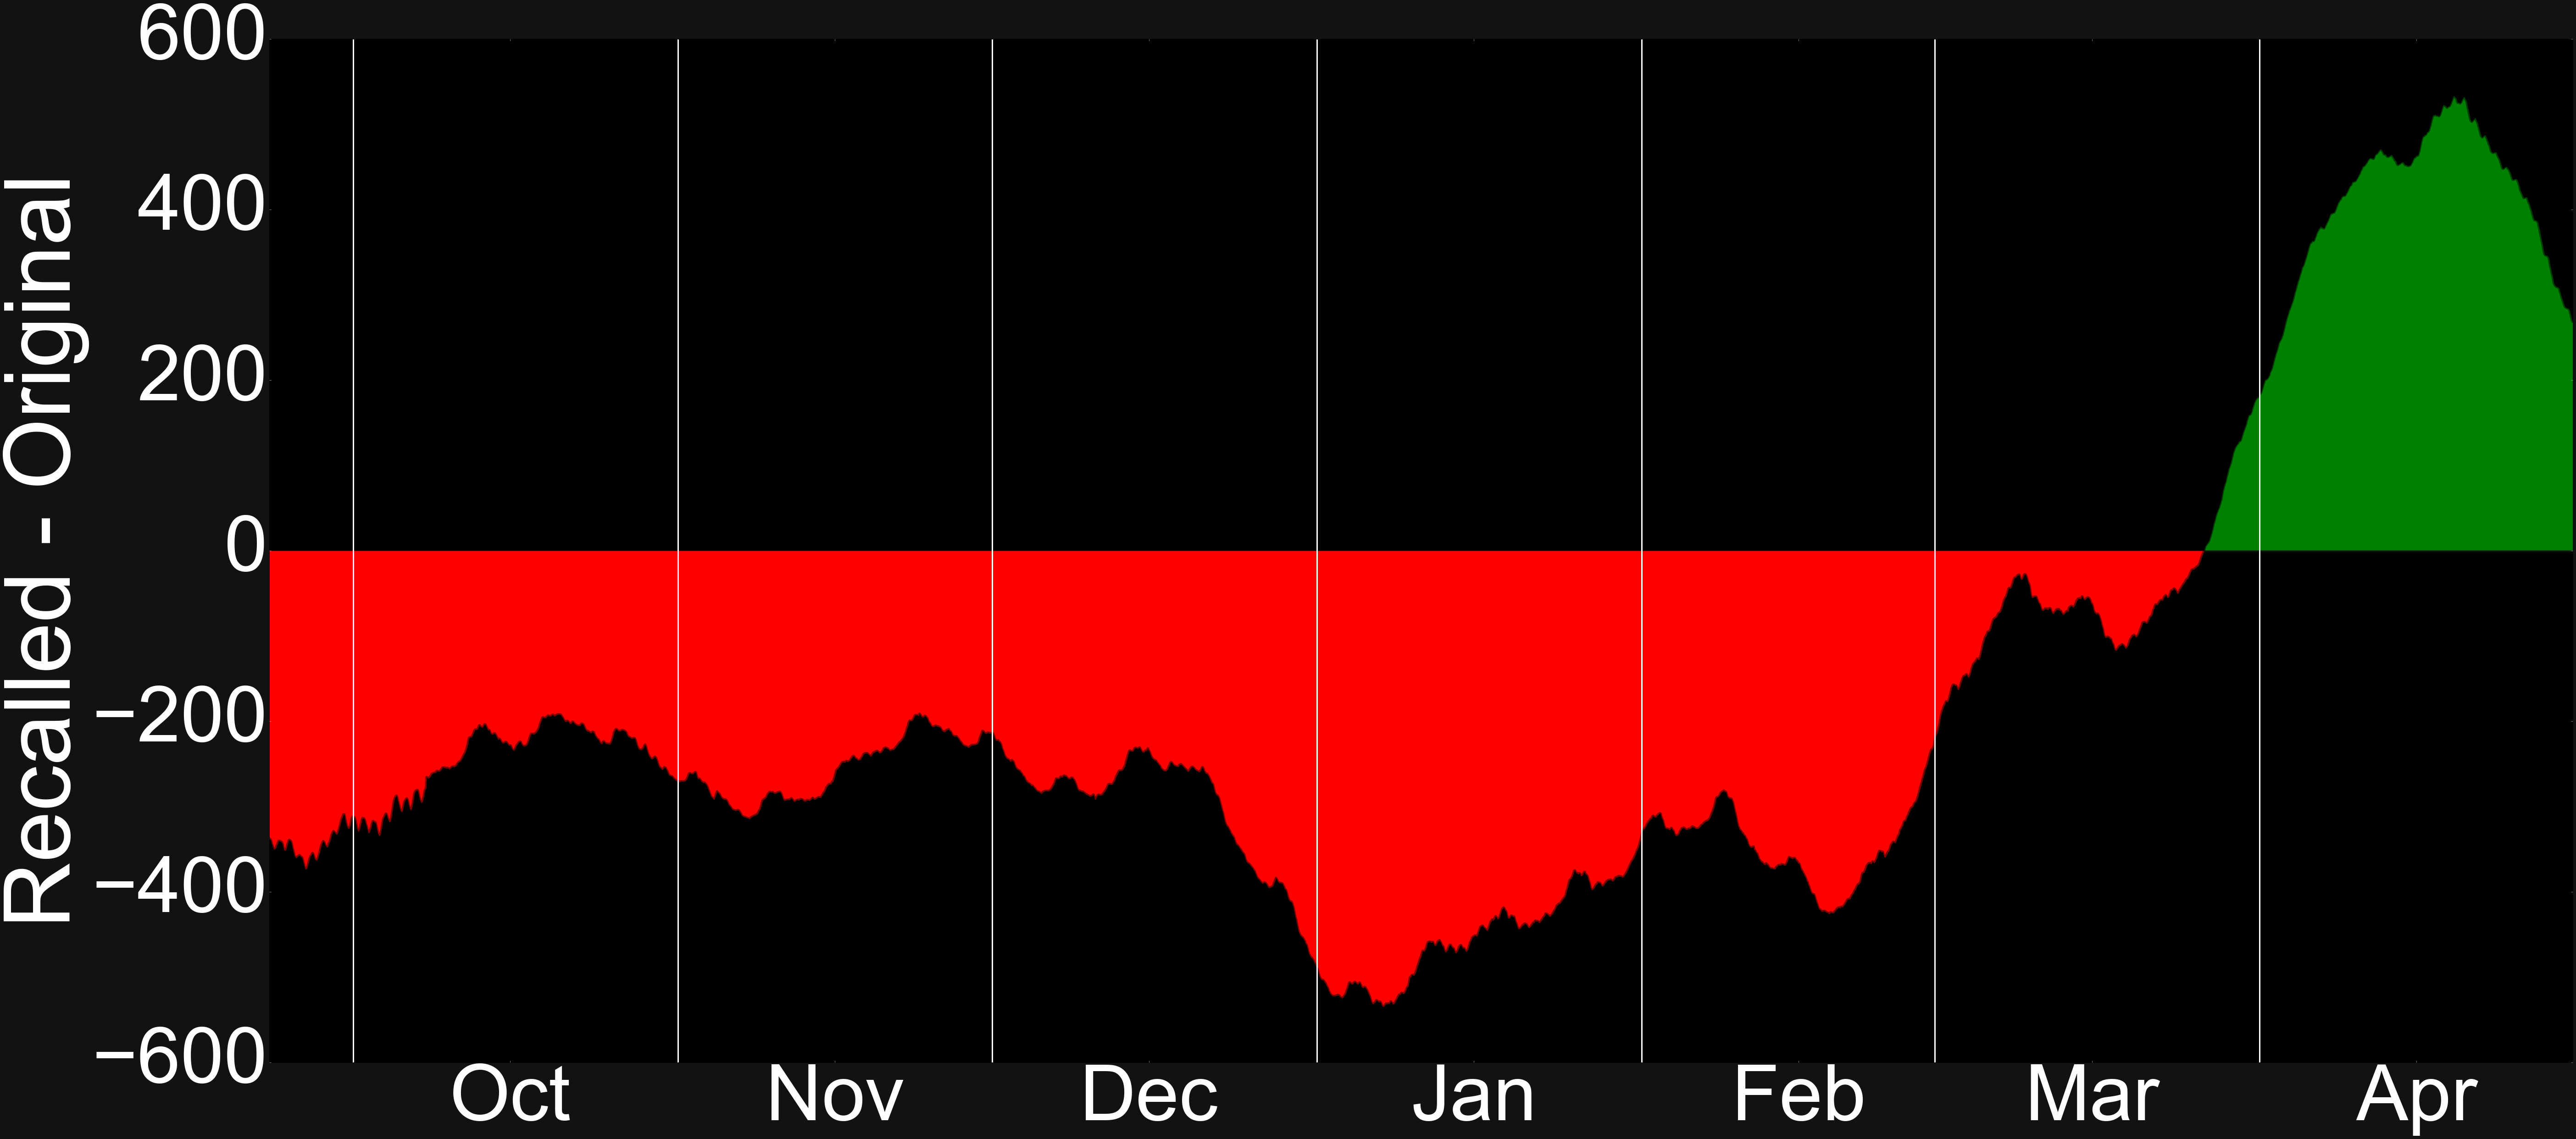

In [106]:
# pl.plot(filtered - min(filtered), 'r', linewidth=5)
# pl.plot(filtered_recalled - min(filtered_recalled), 'g', linewidth=5)
pl.plot(x, difference, 'black', linewidth=5, alpha=0.5)
pl.plot(d, 'black')
# pl.fill_between(x, difference, where=(difference > d), interpolate = True, color='g', alpha=0.5)
# pl.fill_between(x, difference, where=(difference < d), interpolate = True, color='r', alpha=0.5)
pl.fill_between(x, difference, where=(difference > d), interpolate = True, color='g')
pl.fill_between(x, difference, where=(difference < d), interpolate = True, color='r')
for xc in x_month[:-1]:
    pl.axvline(x=xc, linewidth=3, color = 'w')
# pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# pl.axvline(x = x_month[4] + 22*24, linewidth=5, color = 'm') #Golden Globe
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.ylabel("Recalled - Original", fontsize=200)
pl.xlim(0,np.shape(difference)[0])
# pl.show()

In [68]:
pl.savefig("apr_recall.svg", format='svg', dpi=200)

In [ ]:
# import pandas as pd

In [ ]:
# init = filtered - min(filtered)
# recall = filtered_recalled[1:] - min(filtered_recalled[1:])
# stack = np.vstack((init, recall)).T

In [ ]:
# df = pd.DataFrame(stack, columns=['a', 'b'])
# df.plot.area(stacked = False);
# df.plot.area();